In [18]:
import pandas as pd
import glob
import matplotlib.pyplot as plt

In [3]:
data_dir = "/users/s1155184323/projects/scATAC-benchmarking/xinda_data/SOX2_ATAC_4.5-6.5"
bed_files = glob.glob(f"{data_dir}/GSM*/GSM*bed")
bed_files_thre5 = glob.glob(f"{data_dir}/GSM*/thre5.bed")
bed_files_thre10 = glob.glob(f"{data_dir}/GSM*/thre10.bed")
bed_files_thre20 = glob.glob(f"{data_dir}/GSM*/thre20.bed")
bed_files_thre50 = glob.glob(f"{data_dir}/GSM*/thre50.bed")
bed_files_thre100 = glob.glob(f"{data_dir}/GSM*/thre100.bed")

In [5]:
bed_df = pd.read_table(bed_files[0], header=None)

In [8]:
bed_df['diff'] = bed_df[2] - bed_df[1] + 1

In [14]:
bed_df.loc[bed_df.iloc[:,4] > 20, 'diff'].min()

3

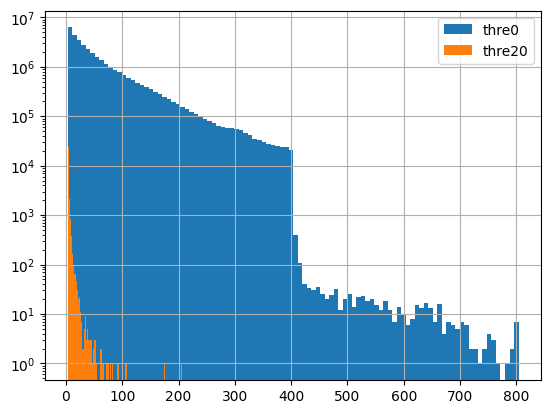

In [19]:
fig, ax = plt.subplots()
bed_df.loc[bed_df.iloc[:,4] > 0, 'diff'].hist(bins=100, ax=ax, label='thre0')
bed_df.loc[bed_df.iloc[:,4] > 20, 'diff'].hist(bins=100, ax=ax, label='thre20')
# set the y axis to log scale
ax.set_yscale('log')
ax.legend()



In [ ]:
reflist=`cat ../reflist.txt`

for ref in $reflist
do
    echo "Converting BigWig to bed $ref"
    bash ./0_bw2bed.sh $ref
done

# sort -k1,1 -k4,4n \
# /users/s1155184323/projects/scATAC-benchmarking/xinda_data/SOX2_ATAC_4.5-6.5/genome_ref/mm9.knownGene.gtf \
# > /users/s1155184323/projects/scATAC-benchmarking/xinda_data/SOX2_ATAC_4.5-6.5/genome_ref/sorted.gtf

# test the annotation mode in $work_dir 
ref_bw="GSM6161425_E55_epiblast_SOX2_CR_rep1.bw"                                                                            # 30471966
annot_file="/users/s1155184323/projects/scATAC-benchmarking/xinda_data/SOX2_ATAC_4.5-6.5/genome_ref/mm9.knownGene.gtf"      # 1133172
bedtools intersect -a $work_dir/${ref_bw%.*}/${ref_bw%.*}.bed -b $annot_file -wa > annot_test_wa.bed                        # 38426614 x
bedtools intersect -a $work_dir/${ref_bw%.*}/${ref_bw%.*}.bed -b $annot_file -wb > annot_test_wb.bed                        # 38426614
bedtools intersect -a $work_dir/${ref_bw%.*}/${ref_bw%.*}.bed -b $annot_file -wa -wb > annot_test_wawb.bed                  # 38426614
bedtools intersect -a $work_dir/${ref_bw%.*}/${ref_bw%.*}.bed -b $annot_file -loj > annot_test_loj.bed                      # 54943905



for ref in $reflist
do
    echo "Annotating $ref"
    bash ./1_annotation.sh $ref
done



# for ref in $reflist
# do
#     echo "Thresholding $ref to >5, 10, 20, 50, and 100"
#     bash ./2_threshold.sh $ref raw
#     bash ./2_threshold.sh $ref annoted_intersect
# done

for ref in $reflist
do
    echo "Spliting $ref to four cell lines"
    bash ./2_split_group.sh $ref
done



source ./config.sh
curreflist=`cat ../reflist.txt | grep "rep1"`

for ref in $curreflist
do
    ref_dir=$work_dir/${ref%.*}
    echo "Calculating matrix for plotting for $ref"
    bash ./3_binding_site_alignment.sh $ref_dir
done



# source ./config.sh
# curreflist=`cat ../reflist.txt | grep "rep1"`

# for ref in $curreflist
# do
#     ref_dir=$work_dir/${ref%.*}
#     score_files=`cat $ref_dir/atacfiles.txt`
#     for input_file in $score_files
#     do
#         echo "Plotting for $input_file"
#         for mode in raw annoted_intersect
#         do
#             mtx_file=$ref_dir/${input_file%.*}.${mode}_thre20.data.matrix.gz
#             bash ./4_plot_heatmap.sh $mtx_file
#         done
#     done
# done


In [ ]:
import os
os.environ["JAVA_HOME"] ="/users/s1155184323/app/jdk-21.0.2"
import pandas as pd
import pyspark.pandas as ps
from pyspark.sql import SparkSession

In [ ]:
annot_test_wawb_df = ps.read_csv("/users/s1155184323/projects/scATAC-benchmarking/xinda_data/SOX2_ATAC_4.5-6.5/annot_test_wawb.bed", sep="\t", header=None)
annot_test_wb_df = ps.read_csv("/users/s1155184323/projects/scATAC-benchmarking/xinda_data/SOX2_ATAC_4.5-6.5/annot_test_wb.bed", sep="\t", header=None)
annot_test_loj_df = ps.read_csv("/users/s1155184323/projects/scATAC-benchmarking/xinda_data/SOX2_ATAC_4.5-6.5/annot_test_loj.bed", sep="\t", header=None)

In [1]:
import pandas as pd
import numpy as np
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 36 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
ref_dir = "/users/s1155184323/projects/scATAC-benchmarking/xinda_data/SOX2_ATAC_4.5-6.5/genome_ref"

In [3]:
mm9_known_gene_df = pd.read_csv(f"{ref_dir}/mm9.knownGene.gtf", sep="\t", header=None)
mm9_ref_gene_df = pd.read_csv(f"{ref_dir}/mm9.refGene.gtf", sep="\t", header=None)

In [6]:
def att2dict(attstr):
    atts = attstr.split(";")
    att_dict = {}
    for att in atts:
        try:
            att_key, att_val = att.split()
            att_dict[att_key] = att_val.replace('"', '')
        except:
            pass
    return att_dict

In [7]:
known_gene_attr_list = mm9_known_gene_df.iloc[:,-1].parallel_apply(att2dict)
ref_gene_attr_list = mm9_ref_gene_df.iloc[:,-1].parallel_apply(att2dict)

In [8]:
mm9_known_gene_df = mm9_known_gene_df.join(pd.DataFrame(known_gene_attr_list.tolist()))
mm9_ref_gene_df = mm9_ref_gene_df.join(pd.DataFrame(ref_gene_attr_list.tolist()))

In [19]:
known_gene_list = [s.upper() for s in mm9_known_gene_df['gene_name'].unique() if type(s) == str]
ref_gene_list = [s.upper() for s in mm9_ref_gene_df['gene_name'].unique() if type(s) == str]

In [20]:
expected_gene_list = ["pou5f1", "Nanog", "SOX2", "GATA6", "EOMES", "SOX17", "ISL1", "HAND1", "TBX3", "GBX2", "SOX1", "PAX6"]

In [26]:
len(set(expected_gene_list).intersection(set(ref_gene_list)))

10

In [24]:
ref_gene_list

['RBFOX2',
 'HIPK3',
 'PFKFB3',
 'GPD2',
 'EMP1',
 'ARID3A',
 'ANKRD13D',
 'FBXL7',
 'HIF1AN',
 'TMEM198',
 'CELF5',
 'TRMT9B',
 'TRPA1',
 'GTF2E2',
 'SLC6A7',
 'BBS9',
 'VXN',
 'MARVELD2',
 'ARAP2',
 'POF1B',
 'EAR7',
 'NRAP',
 'COQ5',
 'SDHAF4',
 'HENMT1',
 'UBE2W',
 'DTNBP1',
 'TMCO5B',
 'ATG10',
 'CCDC43',
 'NHEJ1',
 'TEKT2',
 'IYD',
 'RTKN2',
 '1810064F22RIK',
 'GLI3',
 'HSD17B3',
 'RFC5',
 'WDFY1',
 'CIAO2B',
 'APOO',
 'KCTD6',
 'PEX1',
 'GM8615',
 '9930104L06RIK',
 'PTPRD',
 'KITL',
 'ZBTB18',
 'SLC36A4',
 'SPATS2L',
 'TIMD2',
 'DGKG',
 'PRPF39',
 'AI593442',
 'CORO2A',
 'ZMYND11',
 'ZNRD1',
 'SCMH1',
 'BRICD5',
 'CTSQ',
 'PRDM8',
 'EFCAB6',
 'MIR6971',
 'MIR6970',
 'MIR6968',
 'GM15545',
 'AI847159',
 'MIRA',
 'BEST1',
 'EFTUD2',
 'SEMA4B',
 'OLFR480',
 'TSPAN32',
 'CAMK2N1',
 'DIMT1',
 'TRPM5',
 'DDX55',
 'VMN2R3',
 'ZFP655',
 'CYP19A1',
 'RPS28',
 'SPDYE4B',
 'PIAS3',
 'SBSN',
 'AK4',
 'SCN3A',
 'PGD',
 'REV1',
 'CDIP1',
 'GM2109',
 'KTN1',
 'IPO5',
 'OGFOD3',
 'CYP2S1',
 'SY